# Generate Legacy + Halpha Figures

* for ALMA targets

In [276]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from astropy.io import fits
from astropy.wcs import WCS

from astropy.visualization import simple_norm
from astropy import units as u
from scipy.stats import scoreatpercentile


from astropy.cosmology import FlatLambdaCDM

# In this case we just need to define the matter density 
# and hubble parameter at z=0.

# Note the default units for the hubble parameter H0 are km/s/Mpc. 
# You can also pass an astropy `Quantity` with the units specified. 

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)



In [37]:
homedir = os.getenv("HOME")

In [38]:
cutoutpath = os.path.join(homedir,'research/Virgo/all-cutouts-20210309','')
print(cutoutpath)

/home/rfinn/research/Virgo/all-cutouts-20210309/


In [290]:
%run ~/github/Virgo/programs/readtables.py

In [415]:
def add_scale(ax,vr=1100,pscale=.331,barsize=5.,color='k'):
    '''
    ax = axis for drawing on
    vr = cosmic recession velocity
    pscale = pixel scale, in arcsec/pix
    barsize = size of marker in kpc
    '''
    z = vr/3.e5
    # get Mpc/radians
    add = cosmo.angular_diameter_distance(z)

    # convert to kpc/arcsec
    
    add_kpc_arcsec = add.value*1000*np.pi/(180*3600)
    
    # convert barsize from kpc to arcsec
    barsize_arcsec = barsize/add_kpc_arcsec
    
    # convert barsize from arcsec to pixels
    barsize_pixels = barsize_arcsec/pscale
    
    # get size of image
    x1,x2 = plt.gca().get_xlim()
    xline1 = x1 + 0.1*(x2-x1)
    y1,y2 = plt.gca().get_ylim()
    yline1 = y1 + 0.1*(y2-y1)
    # for size label
    xtext = xline1 + 0.5*barsize_pixels
    ytext = yline1 - 0.08*(y2-y1)
    
    # set up arrays for reference line
    xbar = np.array([xline1,xline1+barsize_pixels])
    ybar = np.array([yline1,yline1])  
    # plot line
    plt.plot(xbar,ybar,'r-',lw=2,color=color)
    
    # label line
    plt.text(xtext,ytext,'{:.0f} kpc'.format(barsize),horizontalalignment='center',fontsize=13,c=color)
    #plt.arrow(xline1,yline1,barsize_pixels,0)
    # draw line to show size of barsize

In [470]:

def display_gal(legacy_jpg,legacy_r,ha,percentile1=.5,percentile2=99.5,p1residual=5,p2residual=99,cmap='viridis',zoom=None,pscale=.43,ra=None,dec=None,gname=None):
    
    '''
    ARGS:
    percentile1 = min percentile for stretch of image and model
    percentile2 = max percentile for stretch of image and model
    p1residual = min percentile for stretch of residual
    p2residual = max percentile for stretch of residual
    cmap = colormap, default is viridis
    '''
    # model name
  

    leg_r_data,header = fits.getdata(legacy_r,header=True)
    image,hheader = fits.getdata(ha,header=True)
    jpeg_data = Image.open(legacy_jpg) 
    pngname = os.path.basename(ha).replace('.fits','.png')
    wcs = WCS(header)
    hwcs = WCS(hheader)
    if zoom is not None:
        print("who's zoomin' who?")
        # display central region of image
        # figure out how to zoom

        # get image dimensions and center
        xmax,ymax = image.shape
        if ra is not None:
            xcenter,ycenter = hwcs.wcs_world2pix(ra,dec,1)
            xcenter = int(xcenter)
            ycenter = int(ycenter)
        else:
            xcenter = int(xmax/2)
            ycenter = int(ymax/2)

        # calculate new size to display based on zoom factor
        new_xradius = int(xmax/2/(float(zoom)))
        new_yradius = int(ymax/2/(float(zoom)))

        # calculate pixels to keep based on zoom factor
        x1 = xcenter - new_xradius
        x2 = xcenter + new_xradius
        y1 = ycenter - new_xradius
        y2 = ycenter + new_xradius
         
        # check to make sure limits are not outsize image dimensions
        if (x1 < 1):
           x1 = 1
        if (y1 < 1):
           y1 = 1
        if (x2 > xmax):
           x2 = xmax
        if (y2 > ymax):
           y2 = ymax
        print(x1,x2,y1,y2)
        # cut images to new size
        image = image[x1:x2,y1:y2]
        
        ## CROP JPEG IMAGE
        xmax,ymax = jpeg_data.size
        if ra is not None:
            xcenter,ycenter = wcs.wcs_world2pix(ra,dec,1)
            xcenter = int(xcenter)
            ycenter = int(ymax - ycenter) # maybe this fixes issue?
        else:
            xcenter = int(xmax/2)
            ycenter = int(ymax/2)
        print('ycenter = ',ycenter,ymax/2)

        # calculate new size to display based on zoom factor
        new_xradius = int(xmax/2/(float(zoom)))
        new_yradius = int(ymax/2/(float(zoom)))

        # calculate pixels to keep based on zoom factor
        x1 = xcenter - new_xradius
        x2 = xcenter + new_xradius
        y1 = ycenter - new_yradius
        y2 = ycenter + new_yradius
         
        # check to make sure limits are not outsize image dimensions
        if (x1 < 1):
           x1 = 1
        if (y1 < 1):
           y1 = 1
        if (x2 > xmax):
           x2 = xmax
        if (y2 > ymax):
           y2 = ymax        
        
        print(x1,x2,y1,y2)
        cropped_jpg = jpeg_data.crop((x1, y1, x2, y2))
        #cropped_jpg = jpeg_data.crop((y1, x1, y2, x2))
        #cropped_jpg.save('temp.jpg')
        #jpeg_data = Image.open(cropped_jpg) 
        #return cropped_jpg

    
    v1 = [scoreatpercentile(image,percentile1)]
    #      scoreatpercentile(image,percentile1),
    #      scoreatpercentile(residual,p1residual)]
    v2 = [scoreatpercentile(image,percentile2)]
    #      scoreatpercentile(image,percentile2),
    #      scoreatpercentile(residual,p2residual)]
    norms = [simple_norm(image,'asinh',max_percent=percentile2)]
    #        simple_norm(image,'asinh',max_percent=percentile2),
    #        simple_norm(residual,'linear',max_percent=p2residual)]
               
    plt.figure(figsize=(7,4))
    plt.subplots_adjust(bottom=.01,left=.01,right=.99,top=.9,hspace=0,wspace=0)
   

    #hdu = fits.open(filename)[0]
    

    
    ## PLOT JPEG FROM LEGACY 

    
    if zoom is not None:
        plt.subplot(1,2,1)
        plt.imshow(cropped_jpg)
        plt.gca().set_yticks([])
        plt.gca().set_xticks([])
    else:
        plt.subplot(1,2,1,projection=wcs)
        plt.imshow(jpeg_data, origin='lower')
    #plt.grid(color='white', ls='solid')
    #plt.xlabel('RA (deg)',fontsize=20)
    #plt.ylabel('Dec (deg)',fontsize=20)
    plt.title(r'$Legacy \ grz$',fontsize=20)
    #plt.axis([x1,x2,y1,y2])
    ax1 = plt.gca()
    if gname is not None:
        plt.text(.05,.9,gname,horizontalalignment='left',transform=ax1.transAxes,c='w',fontsize=20)
    
    ## PLOT CS HALPHA DATA
    plt.subplot(1,2,2)#,projection=wcs)
    plt.imshow(image,origin='lower',cmap=cmap,vmin=v1[0],vmax=v2[0],norm=norms[0])
    #plt.xlabel('RA (deg)',fontsize=20)
    #plt.ylabel('Dec (deg)',fontsize=20)
    plt.title(r'$H\alpha$',fontsize=20)
    plt.gca().set_yticks([])
    plt.gca().set_xticks([])
    
    x1,x2=plt.xlim()
    y1,y2=plt.ylim()
    size=15./pscale
    circ= plt.Circle((.9*x2,.1*y2),size,fill=True, color='r')
    plt.gca().add_artist(circ)
    #plt.axis('equal')
    #plt.savefig(pngname)
    return ax1, plt.gca()

In [471]:
# NGC 3504, 5348, 5560, 5577, 

# halpha not ready for 4314,
targets = ['VFID3096','VFID5872','VFID6035','VFID6108','VFID2911']

# VFID3096

vr =    vr  
------
1538.9


who's zoomin' who?
377 1131 377 1131
ycenter =  249 249.5
125 373 125 373


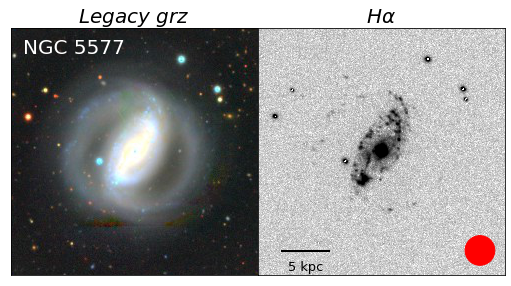

In [473]:
cutouts = os.path.join(cutoutpath,'VFID3096-NGC3504','')
haname = 'VFID3096-NGC3504-v19p070'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID3096-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID3096-legacy-499.jpg')
vr = v.main['vr'][v.main['VFID'] == 'VFID3096']
ned = v.main['NEDname'][vid][0]
print('vr = ',vr)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,cmap='gray_r',zoom=2.,pscale=.331,percentile2=99.6,gname=ned)
add_scale(ax,vr)
vname = 'VFID3096'
plt.savefig(vname+'-rgb-ha.png')

# VFID5872

208.5469185 5.227286
vr =    vr  
------
1450.3


who's zoomin' who?
396 1114 396 1114
ycenter =  219 249.5
132 368 101 337


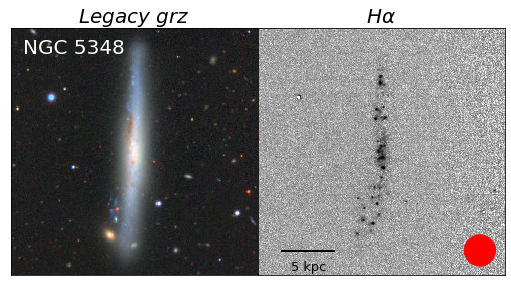

In [474]:
cutouts = os.path.join(cutoutpath,'VFID5872-NGC5348','')
haname = 'VFID5872-NGC5348-v19p120'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID5872-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID5872-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID'] == 'VFID5872']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,cmap='gray_r',zoom=2.1,pscale=.331,percentile2=99.97,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID5872'
plt.savefig(vname+'-rgb-ha.png')

# VFID6035

215.018397 3.992753
vr =    vr  
------
1730.2


who's zoomin' who?
378 1132 378 1132
ycenter =  248 249.5
126 374 124 372


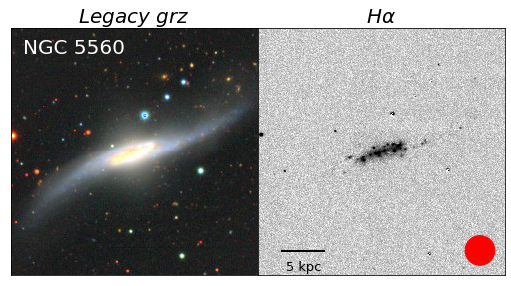

In [475]:
cutouts = os.path.join(cutoutpath,'VFID6035-NGC5560','')
haname = 'VFID6035-NGC5560-v19p131'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID6035-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID6035-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID'] == 'VFID6035']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,cmap='gray_r',zoom=2,pscale=.331,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID6035'
plt.savefig(vname+'-rgb-ha.png')

# VFID 6108

215.30457149999998 3.4358432
vr =    vr  
------
1489.1


who's zoomin' who?
454 1056 454 1056
ycenter =  248 249.5
151 349 149 347


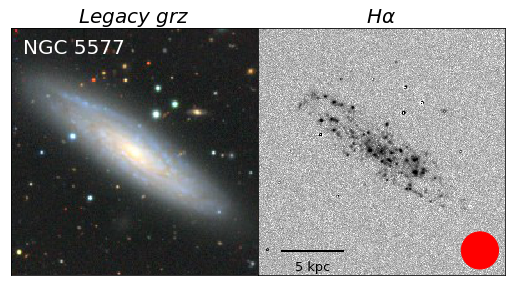

In [476]:
cutouts = os.path.join(cutoutpath,'VFID6108-NGC5577','')
haname = 'VFID6108-NGC5577-v19p134'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID6108-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID6108-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID'] == 'VFID6108']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,cmap='gray_r',zoom=2.5,pscale=.331,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID6108'
plt.savefig(vname+'-rgb-ha.png')

In [477]:
os.getcwd()

'/home/rfinn/github/Virgo/notebooks'